# Spotify Catalog Insights 2025

## 1. Introduction

This project analyzes 2M+ catalog records from Spotify to uncover strategic patterns in the digital music industry. This analysis challenges conventional assumptions about label strategy, artist success, and album composition.

### Key Questions Investigated

The analysis aims to test the following hypotheses:

1. Do larger record labels achieve better performance?

> Conventional wisdom suggests major labels with extensive resources and broad catalogs should outperform smaller independent labels.

2. How concentrated is success on streaming platforms?

> Does Spotify exhibit winner-takes-all dynamics where a small percentage of artists dominate listener engagement?

3. What album composition strategies optimize for popularity?

> Is there an optimal album length that maximizes listener engagement?

### Analytical Approach

This project demonstrates end-to-end data analysis skills by:

- Merging multi-table relational databases using SQL (PostgreSQL) to create unified analytical datasets
  
- Processing 2M+ records to identify statistically significant patterns across label sizes, artist tiers, and album compositions
- Creating strategic categorical groupings to enable comparative analysis
- Generating actionable business recommendations for independent labels, emerging artists, and platform strategy

***

## 2. Data Overview

The project uses three normalized datasets stored in PostgreSQL, representing Spotify's catalog structure as of July 2025. The relational design required SQL joins to enable cross-dimensional analysis.

### Tracks Dataset `spotify_track`

Key fields:

- `durationms` – track length in milliseconds

- `explicit` – content rating flag

- `trackid` - unique track identifier

- `name` - track title

- `albumid` – foreign key to `spotify_album` table

### Albums Dataset `spotify_album`

Key fields:

- `albumid` - unique album identifier

- `artistid` – foreign key to `spotify_artist` table

- `popularity` – album’s Spotify popularity score (0-100)

- `totaltracks` – number of tracks in album

- `label` – record label name

- `releasedate` – release timing

### Artists Dataset `spotify_artist`

Key fields:

- `artist_id` – unique artist identifier

- `name` – artist name

- `popularity` – artist’s Spotify popularity score (0-100)

- `totalfollowers` – number of Spotify followers

- `genres` – genres associated with the artist

***

## 3. Exploratory Data Analysis

### Getting Started

In [295]:
# Import required libraries
import os
import getpass
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sqlalchemy import create_engine
from dotenv import load_dotenv

warnings.simplefilter(action='ignore', category=FutureWarning)

# Load environment variables from .env file
load_dotenv()

# Retrieve database credentials from environment variables
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS')        
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')

# Prompt user for password if not set in environment
if not DB_PASS:
    DB_PASS = getpass.getpass('Enter DB password (will not be shown): ')

# Ensure DB_USER is set; raise error if missing
if not DB_USER:
    raise RuntimeError('Please set DB_USER as an environment variable or in a .env file.')

First, we will set up the environment and database connection for analyzing the `spotify_track` dataset.
It securely loads credentials from a .env file (or prompts for a password if missing) and connects to the PostgreSQL database.

### Preview of Track Database

In [294]:
# Create engine to connect to PostgreSQL database
engine1 = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/spotify_track')

# Execute SQL query and load results into a pandas DataFrame
query_track = 'SELECT * FROM spotify_track'
tracks = pd.read_sql_query(query_track, engine1)
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128954 entries, 0 to 2128953
Data columns (total 12 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   trackid      object
 1   albumid      object
 2   discnumber   int64 
 3   durationms   int64 
 4   explicit     bool  
 5   href         object
 6   isplayable   bool  
 7   name         object
 8   previewurl   object
 9   tracknumber  int64 
 10  type         object
 11  uri          object
dtypes: bool(2), int64(3), object(7)
memory usage: 166.5+ MB


Inspecting column names and data types of the `spotify_track` table ensures we understand the dataset structure before performing any analysis.

In [272]:
tracks.head()

,trackid,albumid,discnumber,durationms,explicit,href,isplayable,name,previewurl,tracknumber,type,uri
0,066w0ykjgvjIJ3ZAoNRcIC,7Fcfb0yt6OH041gPkNF5dd,2,268093,False,https://api.spotify.com/v1/tracks/066w0ykjgvjI...,False,Pes Mou T' Alithina Sou,,11,Track,spotify:track:066w0ykjgvjIJ3ZAoNRcIC
1,7s1ry2syKjqPz781YDAEww,2kwBoDgmIzk8tCuc0eT9My,1,263995,False,https://api.spotify.com/v1/tracks/7s1ry2syKjqP...,False,Osi Zoun Alithina,,5,Track,spotify:track:7s1ry2syKjqPz781YDAEww
2,4uahwprsUDmwPNF7vd6r2X,2kwBoDgmIzk8tCuc0eT9My,1,265925,False,https://api.spotify.com/v1/tracks/4uahwprsUDmw...,False,Ke Pali Edo,,9,Track,spotify:track:4uahwprsUDmwPNF7vd6r2X
3,1bSENgNEsJQbjzVoaYg78O,7legp8gFOT0iY5PTkpAeYC,1,196586,False,https://api.spotify.com/v1/tracks/1bSENgNEsJQb...,False,Sousamosoupes Ke... Alla,,1,Track,spotify:track:1bSENgNEsJQbjzVoaYg78O
4,3xMIK15ZQ3DLr6Gr5PTZEx,0qPxDVSSqXVPXNsMS1Vi1B,1,220062,False,https://api.spotify.com/v1/tracks/3xMIK15ZQ3DL...,False,Strose to Stroma Sou,,11,Track,spotify:track:3xMIK15ZQ3DLr6Gr5PTZEx


### Checking for Missing and Duplicate Values

In [273]:
# Check for missing values in each column
print('Missing values per column:\n', tracks.isnull().sum())

# Check for duplicate track entries based on trackid
print(f"\nDuplicate rows present: {tracks.duplicated(subset=['trackid']).sum()}")

Missing values per column:
 trackid        0
albumid        0
discnumber     0
durationms     0
explicit       0
href           0
isplayable     0
name           0
previewurl     0
tracknumber    0
type           0
uri            0
dtype: int64

Duplicate rows present: 0


Checking for missing values and duplicate tracks will ensure that subsequent analyses are accurate and representative of normal listening patterns. The results show that there are no values that are missing or duplicated and the attributes are the correct types for our purpose.

### Track Duration Distribution

We can filter the `spotify_track` dataset to include only tracks with durations between 0 milliseconds and 15 minutes.
While the dataset contains some unusually long tracks, restricting the range to 15 minutes focuses the analysis on typical listener experiences, where most songs fall within a standard duration.

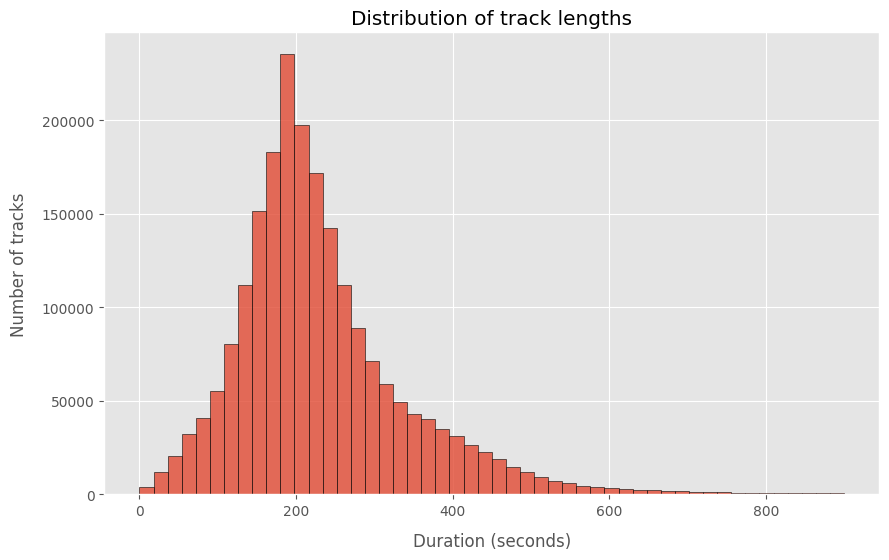

In [274]:
# SQL query to select tracks with durations between 0 ms and 900,000 ms (15 minutes)
query_duration = '''
SELECT trackid, name, durationms 
FROM spotify_track 
WHERE durationms > 0
    AND durationms <= 900000
'''

duration = pd.read_sql_query(query_duration, engine1)

# Convert track duration from milliseconds to seconds for easier interpretation
duration['duration_sec'] = (duration['durationms'] / 1000).astype(int)

# Plot a histogram to visualize the distribution of track lengths
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.hist(duration['duration_sec'], bins=50, edgecolor='k', alpha=0.8)
plt.xlabel('Duration (seconds)', labelpad=10)
plt.ylabel('Number of tracks', labelpad=10)
plt.title('Distribution of track lengths')
plt.show()

Converting the track durations from milliseconds to seconds makes the values more intuitive for visualization.
A histogram is then plotted to show the distribution of track lengths in the dataset.
The plot reveals that most tracks are around 200 seconds (approximately 3–4 minutes), highlighting typical song durations and listener patterns, while still focusing on the usual range under 15 minutes.

### Explicit Content Distribution

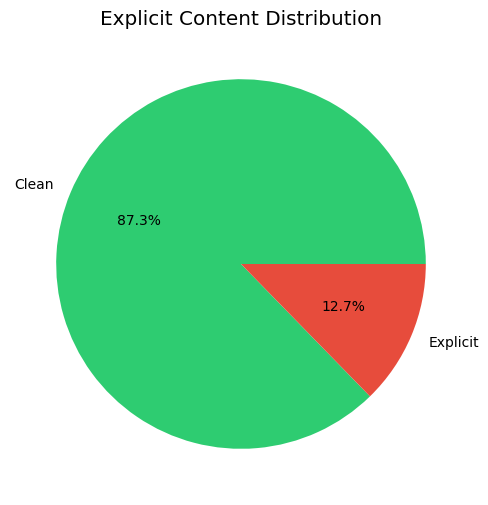

In [275]:
# SQL query to retrieve the 'explicit' column from spotify_track
query_explicit = 'SELECT explicit FROM spotify_track'

# Execute query and load results into a pandas DataFrame
explicit = pd.read_sql_query(query_explicit, engine1)

# Group by explicit flag to count how many tracks are explicit vs. non-explicit
explicit_grp = explicit.groupby('explicit').size()

# Plot a pie chart showing the distribution of explicit tracks
plt.figure(figsize=(10,6))
plt.pie(
    explicit_grp,
    labels=['Clean','Explicit'],
    autopct='%1.1f%%',                    # Display percentages with 1 decimal place
    colors=['#2ecc71', '#e74c3c']
)
plt.title('Explicit Content Distribution')
plt.show()

By grouping and counting each category, we find that the majority of tracks are clean/non-explicit (87.3%).

### Preview of Album Database

In [297]:
# Create engine to connect to the 'spotify_album' database
engine2 = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/spotify_album')

# SQL query to select all rows from spotify_album where the album type is 'album'
query_album = '''
SELECT *
FROM spotify_album 
WHERE albumtype='album' 
'''

# Execute query and load results into a pandas DataFrame
albums = (
    pd.read_sql_query(query_album, engine2)
      .rename(columns={          # Rename columns for better clarity
          'albumid':'album_id',
          'albumgroup':'album_group',
          'name':'album_name',
          'albumtype':'album_type',
          'releasedate':'release_date',
          'releasedateprecision':'release_date_precision',
          'totaltracks':'total_tracks',	
          'previewurl':'preview_url',
          'uri':'album_uri',
          'popularity':'album_popularity',
          'artistid':'artist_id'
      })
)

albums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99141 entries, 0 to 99140
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   album_id                99141 non-null  object
 1   album_group             99141 non-null  object
 2   album_type              99141 non-null  object
 3   album_name              99141 non-null  object
 4   release_date            99141 non-null  object
 5   release_date_precision  99141 non-null  object
 6   total_tracks            99141 non-null  int64 
 7   type                    99141 non-null  object
 8   album_uri               99141 non-null  object
 9   label                   99141 non-null  object
 10  album_popularity        99141 non-null  int64 
 11  artist_id               99141 non-null  object
dtypes: int64(2), object(10)
memory usage: 9.1+ MB


Since this database also considers a single as a type of album, we can filter out entries with any `albumtype` other than 'album' for clearer analysis.

In [298]:
albums.head()

,album_id,album_group,album_type,album_name,release_date,release_date_precision,total_tracks,type,album_uri,label,album_popularity,artist_id
0,1QT8FuA9QFcEoXIYsGtSTP,album,album,Plan B,2015-10-05,day,15,album,spotify:album:1QT8FuA9QFcEoXIYsGtSTP,Lme Recordz,0,0wtFuGMI10KAGgZRGgHZXr
1,6sF7fE4w1FIUqpfNOw1UYr,album,album,Gönül Sabreyle Sabreyle,2007-03-23,day,8,album,spotify:album:6sF7fE4w1FIUqpfNOw1UYr,Seyhan Müzik Yapım,4,0wtFuGMI10KAGgZRGgHZXr
2,0DJHbL49sGd1ZhXme7N7YN,album,album,Bana Şans Dile,2004,year,8,album,spotify:album:0DJHbL49sGd1ZhXme7N7YN,YAŞAR KEKEVA PLAKÇILIK,19,0wtFuGMI10KAGgZRGgHZXr
3,6abemPzqR6bOkf5nsO4JMM,album,album,JETLAG 2,2024-06-21,day,9,album,spotify:album:6abemPzqR6bOkf5nsO4JMM,PS23-1154 RECORDS,11,3KMRfMxNGZlob5zfIwwnMT
4,6XW9KM7aSa1XrrympVUoYI,album,album,JETLAG,2023-11-24,day,10,album,spotify:album:6XW9KM7aSa1XrrympVUoYI,PS23-1154 RECORDS,12,3KMRfMxNGZlob5zfIwwnMT


### Checking for Missing and Duplicate Values

In [278]:
# Check for missing values in each column of the albums DataFrame
print('Missing values per column:\n', albums.isnull().sum())

# Check for duplicate albums based on the 'album_id' column
print(f"\nDuplicate rows present: {albums.duplicated(subset=['album_id']).sum()}")

Missing values per column:
 album_id                  0
album_group               0
album_type                0
album_name                0
release_date              0
release_date_precision    0
total_tracks              0
type                      0
album_uri                 0
label                     0
album_popularity          0
artist_id                 0
dtype: int64

Duplicate rows present: 641


### Album Popularity Distribution

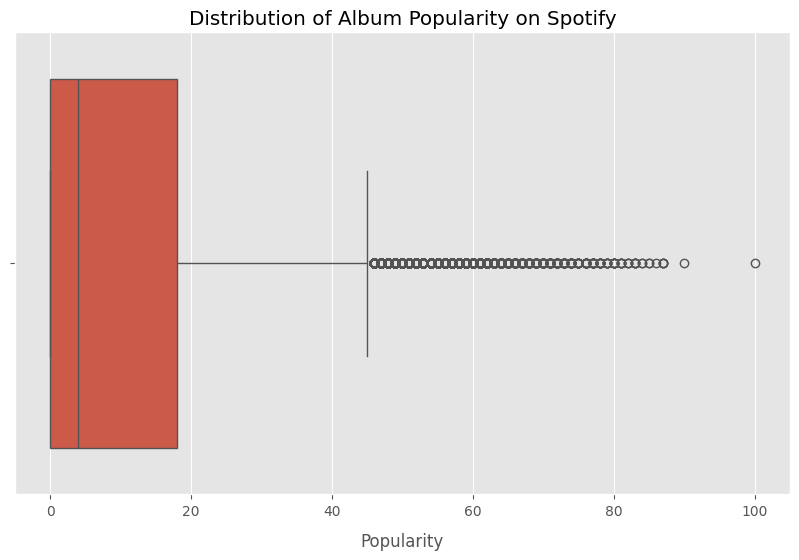

In [279]:
# Plot a boxplot to visualize the distribution of album popularity
plt.figure(figsize=(10,6))
sns.boxplot(x=albums['album_popularity'])
plt.title('Distribution of Album Popularity on Spotify')
plt.xlabel('Popularity', labelpad=10)
plt.show()

This boxplot visualizes the distribution of album popularity (0 - 100).
It highlights the median, quartiles, and potential outliers in popularity scores, helping to understand how album popularity varies across the dataset. We can see that the majority of albums fall under 20/100 popularity and that the number of albums start to get fewer as we get into higher popularity numbers.

### Preview of Artist Database

In [293]:
# Create engine to connect to the 'spotify_artist' database
engine3 = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/spotify_artist')

# Execute query and load results into a pandas DataFrame
query_artist = 'SELECT * FROM spotify_artist'

artists = (
    pd.read_sql_query(query_artist, engine3)
      .rename(columns={          # Rename columns for better clarity
          'id':'artist_id',
          'name':'artist_name',
          'popularity':'artist_popularity',
          'totalfollowers':'total_followers',
          'lastsynctime':'last_sync_time'
      })
)

artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214080 entries, 0 to 214079
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   artist_id          214080 non-null  object        
 1   artist_name        214080 non-null  object        
 2   artist_popularity  214080 non-null  int64         
 3   type               214080 non-null  object        
 4   uri                214080 non-null  object        
 5   total_followers    214080 non-null  int64         
 6   href               214080 non-null  object        
 7   genres             214080 non-null  object        
 8   last_sync_time     214080 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 14.7+ MB


In [296]:
artists.head()

,artist_id,artist_name,artist_popularity,type,uri,total_followers,href,genres,last_sync_time
0,7pWH6NDnA9OtjCt3KbfCno,Lumière,33,artist,spotify:artist:7pWH6NDnA9OtjCt3KbfCno,178,https://api.spotify.com/v1/artists/7pWH6NDnA9O...,,2025-02-26 05:40:44.482755
1,6pY0MQPu7mAEjDmwvw1P4b,Nill Ness,0,artist,spotify:artist:6pY0MQPu7mAEjDmwvw1P4b,308,https://api.spotify.com/v1/artists/6pY0MQPu7mA...,french rap,2000-01-01 00:00:00.000000
2,1BcAEs4W94BrXMmVCOgwSx,Five Iron Frenzy,34,artist,spotify:artist:1BcAEs4W94BrXMmVCOgwSx,49379,https://api.spotify.com/v1/artists/1BcAEs4W94B...,"ska,ska punk,christian rock,christian alternat...",2025-02-23 23:04:18.337825
3,5RADpgYLOuS2ZxDq7ggYYH,Death Grips,57,artist,spotify:artist:5RADpgYLOuS2ZxDq7ggYYH,930121,https://api.spotify.com/v1/artists/5RADpgYLOuS...,"experimental hip hop,experimental,punk rap",2025-02-23 23:04:18.578886
4,0XvMTaHLH69UyJjklyw4Z4,Fabio Farti,6,artist,spotify:artist:0XvMTaHLH69UyJjklyw4Z4,225,https://api.spotify.com/v1/artists/0XvMTaHLH69...,,2000-01-01 00:00:00.000000


### Checking for Missing and Duplicate Values

In [282]:
# Check for missing values in each column of the albums DataFrame
print('Missing values per column:\n', artists.isnull().sum())

# Check for duplicate albums based on the 'artist_id' column
print(f"\nDuplicate rows present: {artists.duplicated(subset=['artist_id']).sum()}")

Missing values per column:
 artist_id            0
artist_name          0
artist_popularity    0
type                 0
uri                  0
total_followers      0
href                 0
genres               0
last_sync_time       0
dtype: int64

Duplicate rows present: 0


### Merging Dataframes

In [283]:
# Create a smaller DataFrame with only artist ID and artist name for merging
artist_id = artists[['artist_id', 'artist_name', 'artist_popularity']].copy()

# Merge albums DataFrame with artist names using artistid as the key
albums_merged = pd.merge(albums, artist_id, on='artist_id', how='inner')

# Display the first few rows of the merged DataFrame
albums_merged.head()

,album_id,album_group,album_type,album_name,release_date,release_date_precision,total_tracks,type,album_uri,label,album_popularity,artist_id,artist_name,artist_popularity
0,1QT8FuA9QFcEoXIYsGtSTP,album,album,Plan B,2015-10-05,day,15,album,spotify:album:1QT8FuA9QFcEoXIYsGtSTP,Lme Recordz,0,0wtFuGMI10KAGgZRGgHZXr,Misa,13
1,6sF7fE4w1FIUqpfNOw1UYr,album,album,Gönül Sabreyle Sabreyle,2007-03-23,day,8,album,spotify:album:6sF7fE4w1FIUqpfNOw1UYr,Seyhan Müzik Yapım,4,0wtFuGMI10KAGgZRGgHZXr,Misa,13
2,0DJHbL49sGd1ZhXme7N7YN,album,album,Bana Şans Dile,2004,year,8,album,spotify:album:0DJHbL49sGd1ZhXme7N7YN,YAŞAR KEKEVA PLAKÇILIK,19,0wtFuGMI10KAGgZRGgHZXr,Misa,13
3,6abemPzqR6bOkf5nsO4JMM,album,album,JETLAG 2,2024-06-21,day,9,album,spotify:album:6abemPzqR6bOkf5nsO4JMM,PS23-1154 RECORDS,11,3KMRfMxNGZlob5zfIwwnMT,Misa,19
4,6XW9KM7aSa1XrrympVUoYI,album,album,JETLAG,2023-11-24,day,10,album,spotify:album:6XW9KM7aSa1XrrympVUoYI,PS23-1154 RECORDS,12,3KMRfMxNGZlob5zfIwwnMT,Misa,19


In [284]:
# Print the total number of values (cells) in the merged DataFrame
print(f"\nNumber of rows: {albums_merged.size}")


Number of rows: 1320452


This cell merges album-level data with artist names to create a comprehensive dataset combining album and artist information.
The merge uses `artist_id` as the key to ensure accurate alignment.
The resulting `albums_merged` DataFrame can now be used for analyses allowing easy identification of the artist associated with the album.

### Artist Concentration

In [285]:
# Categorize artists by popularity into tiers
albums_merged['artist_tier'] = pd.cut(
    albums_merged['artist_popularity'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['Niche (<20)', 'Emerging (20-39)', 'Mid-Tier (40-59)', 'Popular (60-79)', 'Superstars (80+)']
)

# Aggregate number of artists, number of albums, and average album popularity per tier
results = albums_merged.groupby('artist_tier').agg({
    'artist_id':'nunique',
    'album_id':'nunique',
    'album_popularity':'mean'
}).rename(columns={
    'artist_id':'num_artists',
    'album_id':'num_albums',
    'album_popularity':'avg_album_popularity'
})

# Display aggregated results
print(results)
print(f'Total number of artists: {sum(results['num_artists'])}')

                  num_artists  num_albums  avg_album_popularity
artist_tier                                                    
Niche (<20)              8104       30592              2.622403
Emerging (20-39)         4338       27330              9.881597
Mid-Tier (40-59)         2570       20229             20.860716
Popular (60-79)           788        8301             31.314409
Superstars (80+)           72         551             57.952813
Total number of artists: 15872


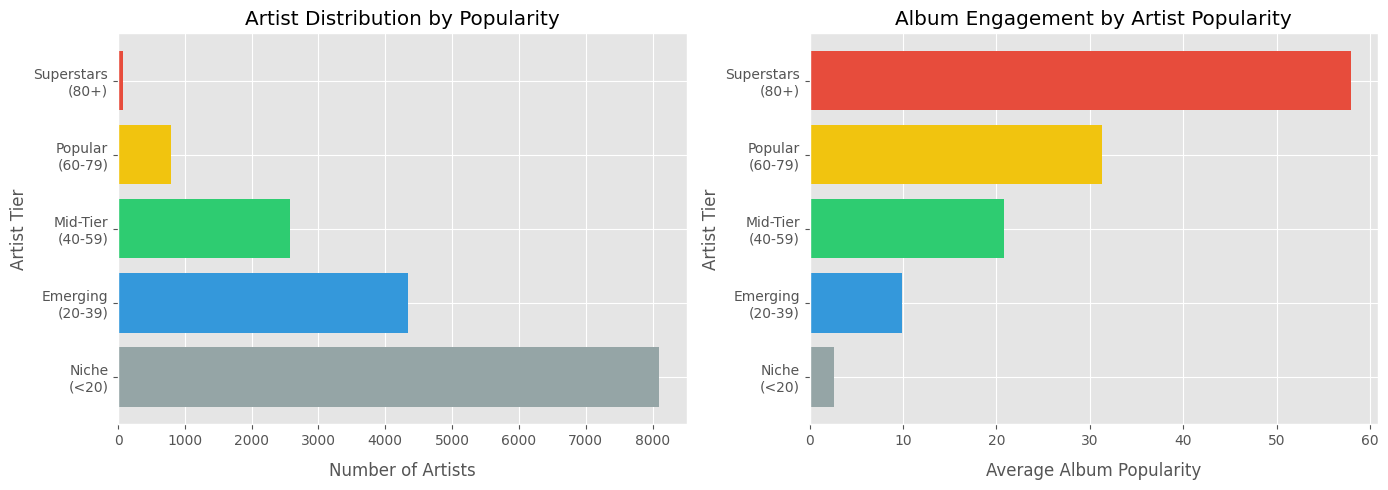

In [286]:
artist_data = {'Artist Tier': ['Niche\n(<20)', 'Emerging\n(20-39)', 'Mid-Tier\n(40-59)', 'Popular\n(60-79)', 'Superstars\n(80+)'],
               'Number of Artists': [8104, 4338, 2570, 788, 72],
               'Average Album Popularity': [2.62, 9.88, 20.86, 31.31, 57.95]}

colors = ['#95a5a6', '#3498db', '#2ecc71', '#f1c40f', '#e74c3c']

df_artists = pd.DataFrame(artist_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.barh(df_artists['Artist Tier'], df_artists['Number of Artists'], color=colors)
ax1.set_xlabel('Number of Artists', labelpad=10)
ax1.set_ylabel('Artist Tier')
ax1.set_title('Artist Distribution by Popularity')


ax2.barh(df_artists['Artist Tier'], df_artists['Average Album Popularity'], color=colors)
ax2.set_xlabel('Average Album Popularity', labelpad=10)
ax2.set_ylabel('Artist Tier')
ax2.set_title('Album Engagement by Artist Popularity')

plt.tight_layout()
plt.show()

Average album popularity of top 5% artists:

$\frac{(788 × 31.31) + (72 × 57.95)}{860} = 33.5$

Average album popularity of bottom 95% artists:

$\frac{(8104 × 2.62) + (4338 × 9.88) + (2570 × 20.86)}{15012} = 7.8$

Artists were segmented into popularity tiers and evaluated by average album popularity. Popular (60-79) artists and Superstars (80+) represent roughly the top 5% of artists (860 out of 15,800+), yet achieve over 4.3× higher per-album engagement (33.5 avg) than the remaining 95% (7.8 avg). This highlights a strong concentration of engagement among a small subset of highly popular artists.

### Album Length vs. Album Popularity

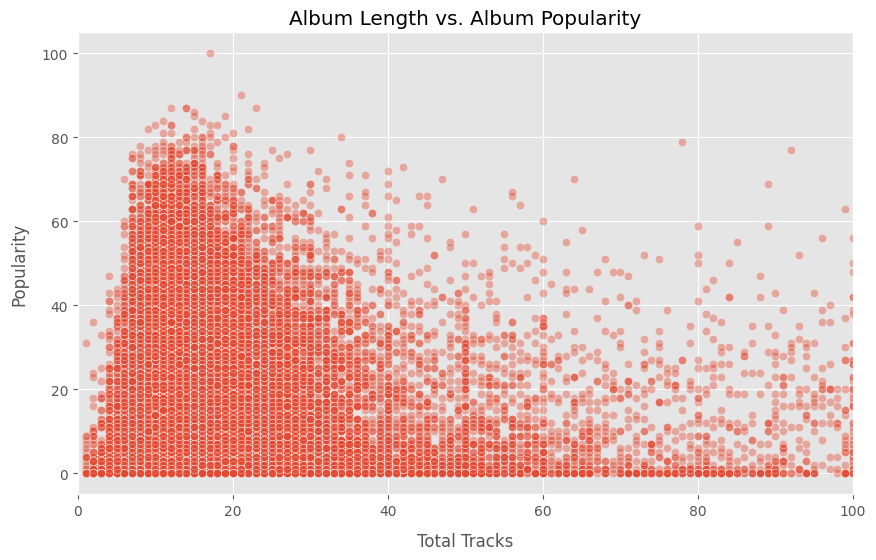

In [287]:
# Plot the relationship between total tracks per album and popularity
plt.figure(figsize=(10,6))

# Scatter plot with regression line; set transparency for better visibility
sns.scatterplot(
    data=albums_merged,
    x='total_tracks',
    y='album_popularity',
    alpha=0.4
)

# Limit x-axis to 0–100 tracks for clarity
plt.xlim(0,100)
plt.xlabel('Total Tracks', labelpad=10)
plt.ylabel('Popularity', labelpad=10)
plt.title('Album Length vs. Album Popularity')
plt.show()

This scatter plot explores the relationship between the number of tracks on an album and its popularity score.
Limiting the x-axis to 0–100 tracks focuses on the typical album range.

In [288]:
# Calculate and print the average number of tracks per album
average_tracks = int(np.mean(albums_merged['total_tracks']))
print(f"Average number of tracks per album: {average_tracks}")

Average number of tracks per album: 16


In [300]:
# Analyze album popularity by album length
# 1. Categorize albums by number of tracks (EP, Standard, Long, Very Long, Deluxe/Extended)
# 2. Aggregate album count, average popularity, and popularity standard deviation by category
album_length_performance_query = '''
SELECT
    CASE
        WHEN totaltracks <= 8 THEN 'EP (<=8 tracks)'
        WHEN totaltracks <= 12 THEN 'Standard (9-12 tracks)'
        WHEN totaltracks <= 16 THEN 'Long (13-16 tracks)'
        WHEN totaltracks <= 20 THEN 'Very Long (17-20 tracks)'
        ELSE 'Deluxe/Extended (20+ tracks)'
    END AS album_length,
    COUNT(DISTINCT albumid) as num_albums,
    AVG(popularity) as avg_album_popularity,
    STDDEV(popularity) as std_dev
FROM spotify_album
WHERE albumtype='album'
GROUP BY album_length
ORDER BY album_length
'''

# Load query results into a pandas DataFrame
album_length_performance = pd.read_sql_query(album_length_performance_query, engine2)

# Display results
album_length_performance

,album_length,num_albums,avg_album_popularity,std_dev
0,Deluxe/Extended (20+ tracks),14311,11.057153,14.433289
1,EP (<=8 tracks),17283,6.450751,11.410552
2,Long (13-16 tracks),20649,13.741387,16.422901
3,Standard (9-12 tracks),36744,11.701656,15.093293
4,Very Long (17-20 tracks),9513,11.944149,15.362139


Albums were grouped by total track count and evaluated by average popularity. Long albums (13–16 tracks) show the highest average popularity (13.74), outperforming both shorter EPs (6.46) and extended releases (11.06). High standard deviations across all categories indicate substantial within-group variation, suggesting album length alone does not determine success—performance is likely moderated by artist tier and genre conventions. This aligns with the overall average album length of 16 tracks observed in the dataset and supports the non-linear relationship seen in the scatterplot.

### Top Labels by Average Album Popularity

In [290]:
# Group albums by label, calculate average popularity per label
top_labels = (
    albums.groupby('label', as_index=False)
          .agg(avg_popularity=('album_popularity', 'mean'))
          .sort_values(by='avg_popularity', ascending=False)  # Sort descending to find top labels
          .head(10)  # Keep only top 10 labels
)

# Display the top 10 labels by average album popularity
print(top_labels.to_string(index=False))

                                       label  avg_popularity
                       2024 Double P Records            90.0
                    Chappell Roan PS/ Island            87.0
      Top Dawg Entertainment/Capitol Records            81.5
                                  Syco Music            78.8
              Universal Music Latino / Rimas            78.0
              Warner Music Nashville/Elektra            77.0
Amaru Entertainment, Inc./Interscope Records            76.0
                      OVO / Republic Records            76.0
                                        2018            76.0
                          A Star is Born OST            75.0


### Label Size vs. Album Performance

In [301]:
# Analyze album performance by record label size
# 1. Count albums per label
# 2. Categorize labels: Small, Mid, Large, Major
# 3. Aggregate album count, average popularity, and label count by category
label_size_performance_query = '''
WITH label_sizes AS (
    SELECT 
        label,
        COUNT(DISTINCT albumid) as album_count
    FROM spotify_album
    WHERE albumtype='album' 
    GROUP BY label
)
SELECT 
    CASE 
        WHEN ls.album_count < 50 THEN 'Small (1-49 albums)'
        WHEN ls.album_count < 200 THEN 'Mid (50-199 albums)'
        WHEN ls.album_count < 500 THEN 'Large (200-499 albums)'
        ELSE 'Major (500+ albums)'
    END AS label_size,
    COUNT(DISTINCT sa.albumid) as num_albums,
    AVG(sa.popularity) as avg_album_popularity,
    COUNT(DISTINCT ls.label) as num_labels
FROM spotify_album sa
JOIN label_sizes ls ON sa.label = ls.label
WHERE sa.albumtype = 'album'
GROUP BY label_size
ORDER BY avg_album_popularity DESC;
'''

# Execute query and load results into a pandas DataFrame
label_size_performance = pd.read_sql_query(label_size_performance_query, engine2)

# Display results
label_size_performance

,label_size,num_albums,avg_album_popularity,num_labels
0,Mid (50-199 albums),15261,14.487559,179
1,Small (1-49 albums),77550,10.577809,27440
2,Large (200-499 albums),5027,9.794777,15
3,Major (500+ albums),662,9.106881,1


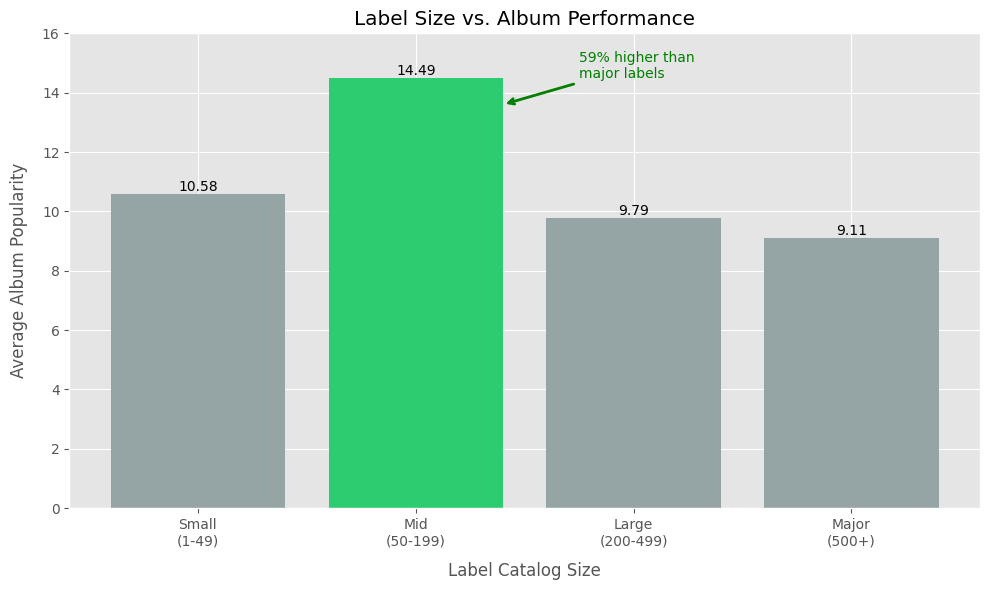

In [303]:
# Prepare dataset of label sizes and average album popularity
label_data = {
    'Label Size': ['Small\n(1-49)', 'Mid\n(50-199)', 'Large\n(200-499)', 'Major\n(500+)'],
    'Average Album Popularity': [10.58, 14.49, 9.79, 9.11]
}

df_labels = pd.DataFrame(label_data)

# Plot bar chart of average album popularity by label size
plt.figure(figsize=(10, 6))
bars = plt.bar(df_labels['Label Size'], df_labels['Average Album Popularity'],
              color=['#95a5a6', '#2ecc71', '#95a5a6', '#95a5a6'])

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

# Set title, axis labels, and y-axis limit
plt.title('Label Size vs. Album Performance')
plt.xlabel('Label Catalog Size', labelpad=10)
plt.ylabel('Average Album Popularity', labelpad=10)
plt.ylim(0,16)

# Highlight key insight with annotation
plt.annotate('59% higher than\nmajor labels', 
             xy=(1.4, 13.6), xytext=(1.75, 14.5),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=10, color='green', )

plt.tight_layout()
plt.show()


Labels were grouped by catalog size and evaluated based on average album popularity. Mid-size labels (50–199 albums) outperform Major labels (500+ albums), achieving a 59% higher average popularity score (14.49 vs. 9.11) despite significantly smaller catalogs. This pattern suggests that focused artist development and curated rosters may offer a competitive advantage over high-volume catalog strategies, underscoring the strategic relevance of mid-size independent labels.

***

## 4. Key Insights and Recommendations

This analysis revealed three primary patterns with strategic implications for music 
industry stakeholders. For detailed recommendations and business applications, see 
the project [README](https://github.com/pktrance/Spotify-Catalog-Insights/blob/main/README.md).

### Primary Findings

**1. Mid-Size Label Advantage**
- Mid-size independent labels (50-199 albums) achieve 59% higher average album 
  popularity compared to major labels (500+ albums)
- Demonstrates that focused artist development and catalog curation outperform 
  volume-based catalog strategies
- Challenges the assumption that scale automatically drives success in digital streaming

**2. Platform Concentration Dynamics**
- Top 5% of artists (60+ popularity) achieve 4.3x higher per-album engagement than 
  remaining 95%
- Only 860 artists out of 15,800+ drive disproportionate platform success
- Reveals winner-takes-all dynamics where established artists compound advantages

**3. Album Composition Patterns**
- Albums with 13-16 tracks show highest popularity (13.74 avg)
- Non-linear relationship contradicts simple "shorter is better" hypothesis
- High variance suggests album length is moderated by artist tier and genre conventions

### Strategic Implications Summary

**For Independent Labels:** Maintain 50-200 album catalogs with deep artist development 
and selective curation

**For Emerging Artists:** Focus on niche audience building; consider mid-size label 
partnerships

**For Platform Strategy:** Recognize mid-size label value; address concentration through 
discoverability features